In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

In [2]:
years = [1991, 2020]
clim_years = [1991, 2020]
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'

In [3]:
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
with xr.open_dataset(f_ice) as fice:
    icemask1=np.nanmax(fice.ice.data,axis=0)>0
    Amax=np.zeros((20,)+np.shape(icemask1))
    for ind in range(0,20):
        Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
    AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)

/tmp/reo000/2328085/ipykernel_2528699/2378323939.py:3: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0
/tmp/reo000/2328085/ipykernel_2528699/2378323939.py:6: RuntimeWarning: All-NaN slice encountered
  Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)


In [4]:
is_detrend=True
il=1

In [5]:

if is_detrend:
    dir = basepath+'/mhw/detrended';
    f_for = f'{dir}/mhw_MME_l{il}_detrended_{years[0]}_{years[1]}.nc'
    f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
else:
    dir = basepath+'/mhw';
    f_for = f'{dir}/mhw_MME_l{il}_{years[0]}_{years[1]}.nc'
    f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'

ffor=xr.open_dataset(f_for) 

In [6]:
fobs=xr.open_dataset(f_obs)

In [7]:
fobs

<xarray.Dataset> Size: 194MB
Dimensions:     (X: 360, Y: 181, S: 360, Mon: 12)
Coordinates:
  * X           (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y           (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * S           (S) float32 1kB 372.0 373.0 374.0 375.0 ... 729.0 730.0 731.0
  * Mon         (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon         (X) float32 1kB ...
    lat         (Y) float32 724B ...
    time        (S) float32 1kB ...
    year        (S) int64 3kB ...
    month       (S) int64 3kB ...
    sst_an_thr  (Mon, Y, X) float64 6MB ...
    is_mhw      (S, Y, X) float64 188MB ...

In [8]:
def calcSEDI_il(il):
    # set number of ensemble members
    if il<=8:
        M=73 # number of ensemble members
    elif il<=9:
        M=73-4 # NASA-GEOSS2S drops out
    else:
        M=73-4-24 # NCEP-CFSv2 drops out
    if is_detrend:
        dir = basepath+'/mhw/detrended';
        f_for = f'{dir}/mhw_MME_l{il}_detrended_{years[0]}_{years[1]}.nc'
        f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    else:
        dir = basepath+'/mhw';
        f_for = f'{dir}/mhw_MME_l{il}_{years[0]}_{years[1]}.nc'
        f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    
    with xr.open_dataset(f_for) as ffor, xr.open_dataset(f_obs) as fobs:
        
        mhwfor=ffor.mhw_prob.data[:(-1*il),...]
        mhwobs=fobs.is_mhw.data[il:,...]
        N_pos=M*mhwfor
        N_neg=M*(1-mhwfor)
        TP=np.where(mhwobs==1,N_pos,0)
        TN=np.where(mhwobs==0,N_neg,0)
        FP=np.where(mhwobs==0,N_pos,0)
        FN=np.where(mhwobs==1,N_neg,0)
        
        # calculate SEDI, summed over time
        Nobs_pos=np.sum(mhwobs,axis=0)
        Nobs_neg=np.sum(1-mhwobs,axis=0)
        F=np.sum(FP,axis=0)/(Nobs_neg*M)
        H=np.sum(TP,axis=0)/(Nobs_pos*M)
        
        SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))

        lmask=np.sum(fobs.is_mhw.data,axis=0)==0
    return lmask,np.ma.masked_where(AmaxH>0.5,SEDI)

/tmp/reo000/2328085/ipykernel_2528699/3289236705.py:33: RuntimeWarning: invalid value encountered in divide
  H=np.sum(TP,axis=0)/(Nobs_pos*M)
/tmp/reo000/2328085/ipykernel_2528699/3289236705.py:35: RuntimeWarning: divide by zero encountered in log
  SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
/tmp/reo000/2328085/ipykernel_2528699/3289236705.py:35: RuntimeWarning: invalid value encountered in subtract
  SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
/tmp/reo000/2328085/ipykernel_2528699/3289236705.py:35: RuntimeWarning: invalid value encountered in divide
  SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))


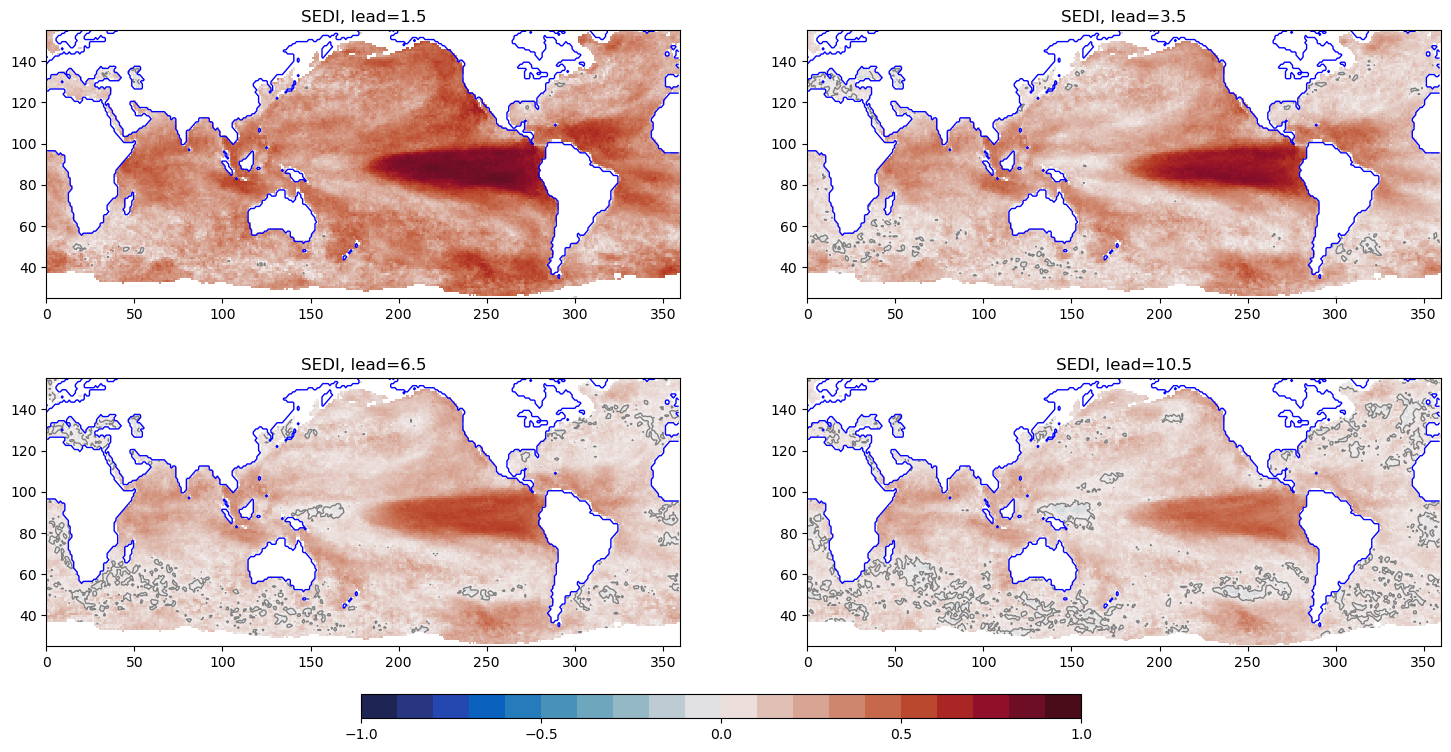

In [9]:
fig,axs=plt.subplots(2,2,figsize=(18,8),gridspec_kw={'hspace':.3})
ax=axs[0,0]; il=1
lm,SEDI=calcSEDI_il(il)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[0,1]; il=3
lm,SEDI=calcSEDI_il(il)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[1,0]; il=6
lm,SEDI=calcSEDI_il(il)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[1,1]; il=10
lm,SEDI=calcSEDI_il(il)
m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ml=fig.add_axes([.3,.02,.4,.03])
fig.colorbar(m,cax=ml,orientation='horizontal',ticks=[-1.0,-.5,0,.5,1.0])